In [1]:
from itertools import product
import random
from typing import List

import japanize_matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pulp
from scipy.spatial import distance

In [2]:
# シード値の固定
SEED = 10

random.seed(SEED)
np.random.seed(SEED)

### 配送先の情報

In [3]:
# 拠点の数
num_of_places: int = 10

# 各拠点のナンバリング
places_list: List = list(range(num_of_places))

# 自社から平均的に100km距離に配達先候補があるとしてデータを作る
# 時速 60km/h -> 100分 -> 100km距離
mean_travel_time_to_destinations = 100

# 各拠点の座標
coordinate_of_places_list = np.random.normal(0, mean_travel_time_to_destinations, size=(num_of_places, 2))

# 出発地点 (= list のうち、一番最初のindexのもの)の座標は (0, 0) とする
coordinate_of_places_list[0] = [0, 0]

# 距離行列
distance_matrix = distance.cdist(coordinate_of_places_list, coordinate_of_places_list, metric='euclidean')

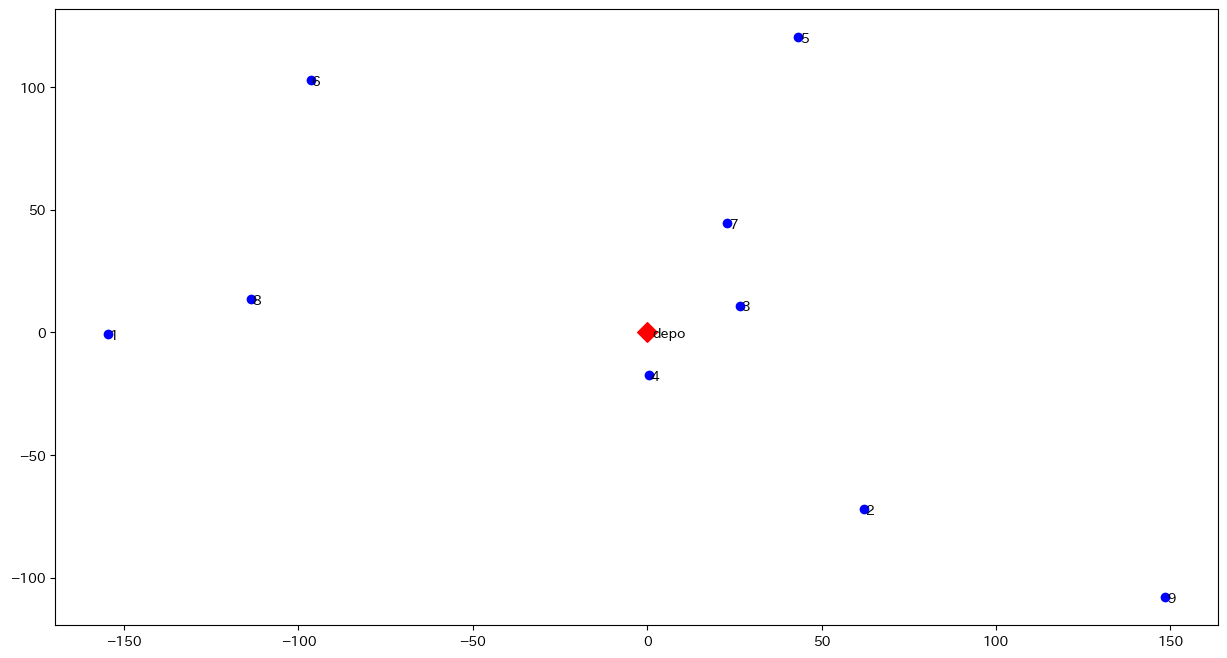

In [4]:
plt.figure(figsize=(15, 8))

plt.scatter(
    coordinate_of_places_list[0, 0],
    coordinate_of_places_list[0, 1],
    color = "red",
    marker = "D",
    s = 100
)

plt.scatter(
    coordinate_of_places_list[1:, 0],
    coordinate_of_places_list[1:, 1],
    color = "blue"
)

for i, coordinate in enumerate(coordinate_of_places_list[1:, :]):

    plt.text(
        coordinate[0] + 0.5,
        coordinate[1] - 2,
        str(i+1)
    )

plt.text(
    coordinate_of_places_list[0, 0] + 1.5,
    coordinate_of_places_list[0, 1] - 2,
    "depo"
);

### 巡回するのは1人、容量制限なし、部分巡回路除去なし

In [5]:
# 目的変数
problem = pulp.LpProblem("TSP", pulp.LpMinimize)

In [6]:
# 変数1 各拠点の訪問数
visit_num = [pulp.LpVariable(f'visit_{i}', cat='Binary') for i in places_list]

In [7]:
# 制約条件1 全部の拠点を訪問する
for i in places_list:
    problem += visit_num[i] == 1

In [8]:
# 変数2 拠点間の移動
route = {
            (i, j):
                pulp.LpVariable(f'route_{i}_{j}', cat='Binary') if i != j else pulp.LpAffineExpression()
            for i, j in product(places_list, places_list)
}

In [9]:
# 制約条件2 移動の構造 全部の拠点を移動する
for i in places_list:
    problem += pulp.lpSum([route[i, j] for j in places_list]) == 1

for j in places_list:
    problem += pulp.lpSum([route[i, j] for i in places_list]) == 1

In [10]:
# 目的条件の設定 移動距離
problem += pulp.lpSum(distance_matrix[i][j] * route[i, j] if i != j else pulp.LpAffineExpression()
                        for j in places_list for i in places_list)

In [11]:
# 解の算定
print(problem.solve())

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/koji/data/vrp/.venv/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/hk/4lvgvfrs6h50_v2lt9mgxgrm0000gn/T/ebb4cd3aa5f2453789788cecd6938662-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/hk/4lvgvfrs6h50_v2lt9mgxgrm0000gn/T/ebb4cd3aa5f2453789788cecd6938662-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 35 COLUMNS
At line 516 RHS
At line 547 BOUNDS
At line 648 ENDATA
Problem MODEL has 30 rows, 100 columns and 190 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 658.129 - 0.00 seconds
Cgl0004I processed model has 20 rows, 90 columns (90 integer (90 of which binary)) and 180 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of 658.129
Cbc0038I Before mini branch and bound, 90 integers at bound fixed an

In [12]:
# 距離
pulp.value(problem.objective)

658.1286645146357

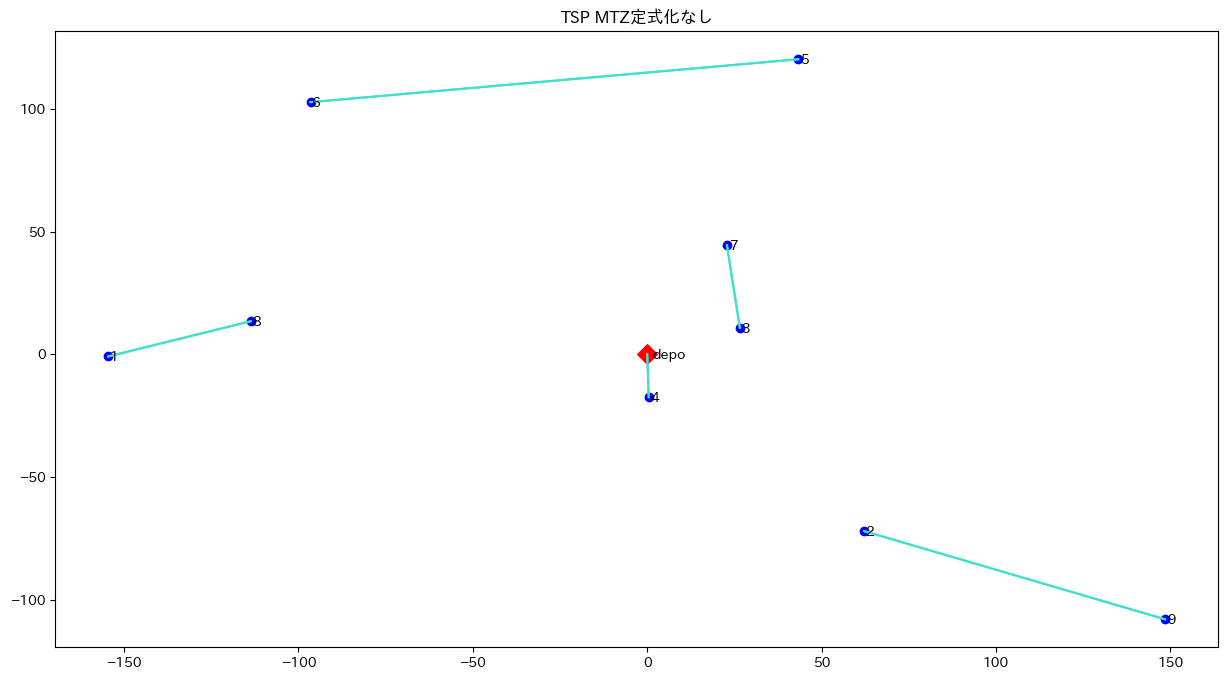

In [13]:
plt.figure(figsize=(15, 8))
plt.title("TSP MTZ定式化なし")

plt.scatter(
    coordinate_of_places_list[0, 0],
    coordinate_of_places_list[0, 1],
    color = "red",
    marker = "D",
    s = 100
)

plt.scatter(
    coordinate_of_places_list[1:, 0],
    coordinate_of_places_list[1:, 1],
    color = "blue"
)

for i, coordinate in enumerate(coordinate_of_places_list[1:, :]):

    plt.text(
        coordinate[0] + 0.5,
        coordinate[1] - 2,
        str(i+1)
    )

plt.text(
    coordinate_of_places_list[0, 0] + 1.5,
    coordinate_of_places_list[0, 1] - 2,
    "depo"
);

for i in places_list:
    for j in places_list:
        if pulp.value(route[i, j]) == 1:
            plt.plot(
                [coordinate_of_places_list[i, 0], coordinate_of_places_list[j, 0]],
                [coordinate_of_places_list[i, 1], coordinate_of_places_list[j, 1]],
                color = "turquoise"
            )

In [14]:
for i in places_list:
    for j in places_list:
        if pulp.value(route[i, j]) == 1:
            print(f"{i}->{j}")

0->4
1->8
2->9
3->7
4->0
5->6
6->5
7->3
8->1
9->2


### 巡回するのは1人、容量制限なし、部分巡回路除去あり

In [15]:
# 目的変数
problem = pulp.LpProblem("TSP_MTZ", pulp.LpMinimize)

# 変数1 各拠点の訪問数
visit_num = [pulp.LpVariable(f'visit_{i}', cat='Binary') for i in places_list]

# 制約条件1 全部の拠点を訪問する
for i in places_list:
    problem += visit_num[i] == 1

# 変数2 拠点間の移動
route = {
            (i, j):
                pulp.LpVariable(f'route_{i}_{j}', cat='Binary') if i != j else pulp.LpAffineExpression()
            for i, j in product(places_list, places_list)
}

# 制約条件2 移動の構造 全部の拠点を移動する
for i in places_list:
    problem += pulp.lpSum([route[i, j] for j in places_list]) == 1

for j in places_list:
    problem += pulp.lpSum([route[i, j] for i in places_list]) == 1

# 目的条件の設定 移動距離
problem += pulp.lpSum(distance_matrix[i][j] * route[i, j] if i != j else pulp.LpAffineExpression()
                        for j in places_list for i in places_list)

In [16]:
# MTZ 定式化のための補助変数
u = {
        i: pulp.LpVariable(
            f'u_{i}', 
            lowBound=1, 
            upBound=len(places_list) - 1,
        ) for i in places_list[1:]
}

In [17]:
# サイクルの除去
for i, j in product(places_list[1:], places_list[1:]):
    problem += (
        u[i] + 1 <= u[j] + len(places_list[1:]) * (1 - route[i, j])
    )

In [18]:
# 解の算定
print(problem.solve())

# 距離
pulp.value(problem.objective)

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/koji/data/vrp/.venv/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/hk/4lvgvfrs6h50_v2lt9mgxgrm0000gn/T/89e939ddbfdc4d50a00cf202763ef96f-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/hk/4lvgvfrs6h50_v2lt9mgxgrm0000gn/T/89e939ddbfdc4d50a00cf202763ef96f-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 116 COLUMNS
At line 822 RHS
At line 934 BOUNDS
At line 1053 ENDATA
Problem MODEL has 111 rows, 109 columns and 406 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 689.42 - 0.00 seconds
Cgl0003I 0 fixed, 0 tightened bounds, 72 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 72 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 72 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened

893.4272928915565

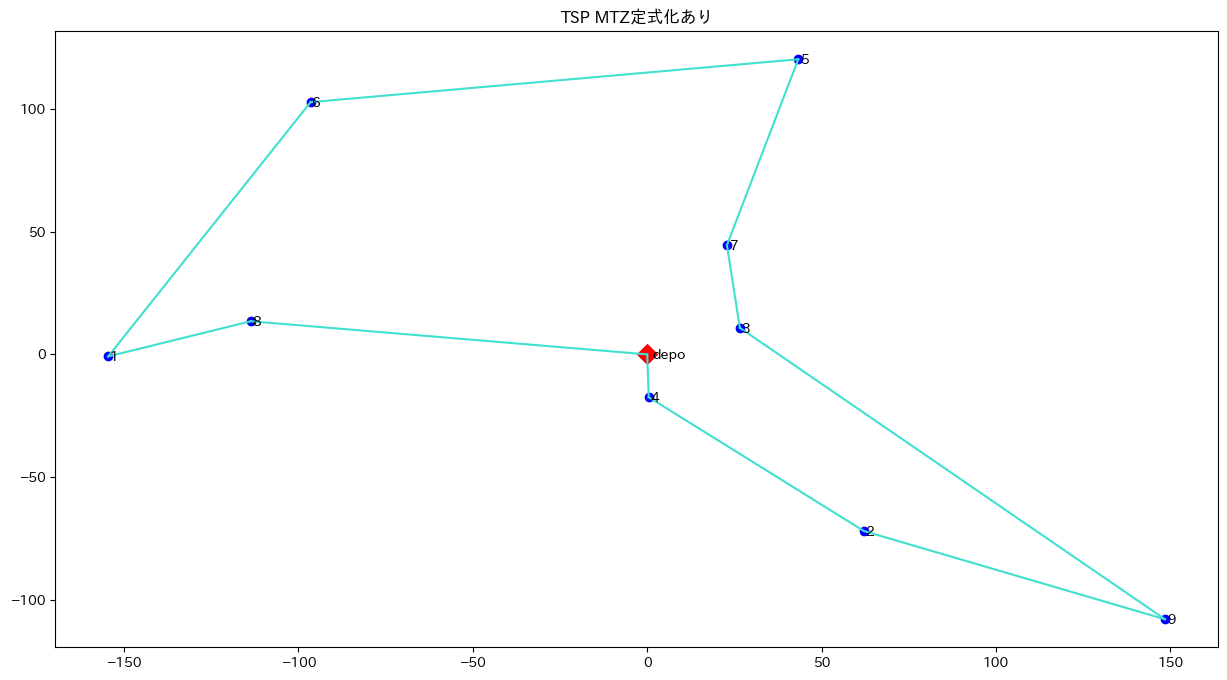

In [19]:
plt.figure(figsize=(15, 8))
plt.title("TSP MTZ定式化あり")

plt.scatter(
    coordinate_of_places_list[0, 0],
    coordinate_of_places_list[0, 1],
    color = "red",
    marker = "D",
    s = 100
)

plt.scatter(
    coordinate_of_places_list[1:, 0],
    coordinate_of_places_list[1:, 1],
    color = "blue"
)

for i, coordinate in enumerate(coordinate_of_places_list[1:, :]):

    plt.text(
        coordinate[0] + 0.5,
        coordinate[1] - 2,
        str(i+1)
    )

plt.text(
    coordinate_of_places_list[0, 0] + 1.5,
    coordinate_of_places_list[0, 1] - 2,
    "depo"
);

for i in places_list:
    for j in places_list:
        if pulp.value(route[i, j]) == 1:
            plt.plot(
                [coordinate_of_places_list[i, 0], coordinate_of_places_list[j, 0]],
                [coordinate_of_places_list[i, 1], coordinate_of_places_list[j, 1]],
                color = "turquoise"
            )

In [20]:
# 最適化結果を出力
for i in places_list:
    for j in places_list:
        if pulp.value(route[i, j]) == 1:
            print(f"{i}->{j}")

0->4
1->8
2->9
3->7
4->2
5->6
6->1
7->5
8->0
9->3


### 車両複数台、容量制限あり、部分巡回路除去あり

[参考サイト](https://qiita.com/r_nsd/items/19dcb30f5478384f90d3)

In [21]:
# 車両台数
num_of_vehicles = 3

# 車両のリスト
vehicles_list = range(num_of_vehicles)

# 車両の最大積載量
vehicle_capacity = 4000

# 荷物の平均的な重さを1000kgとする
average_weight = 1000

# 各荷物の重量。このケースでは荷物の数＝配送先の数としている
weights_list = np.floor(np.random.gamma(10, average_weight/10, size=num_of_places))

# 出発地点の重量はゼロとする
weights_list[0] = 0

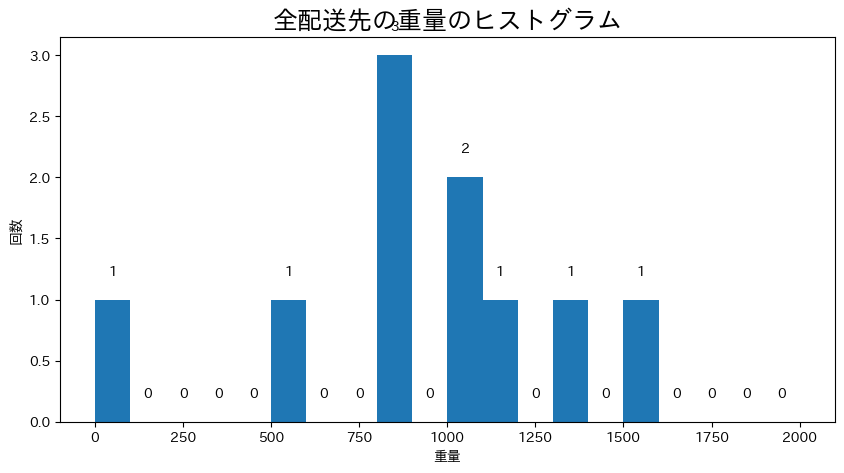

In [22]:
plt.figure(figsize=(10, 5))
plt.title("全配送先の重量のヒストグラム", fontsize=18)
n, bins, _ = plt.hist(weights_list, bins=20, range=(0,2000));

xs = (bins[:-1] + bins[1:])/2
ys = n.astype(int)

for x, y in zip(xs, ys):
    plt.text(x, y+0.2, str(y), horizontalalignment="center")

plt.xlabel("重量");
plt.ylabel("回数");

In [23]:
# 目的変数
problem = pulp.LpProblem("CVRP", pulp.LpMinimize)

# 変数1 各拠点の訪問数
visit_num = {
                vehicle: 
                    {i: pulp.LpVariable(f'visit_{vehicle}_{i}', cat='Binary') for i in places_list} for vehicle in vehicles_list
             }

# 制約条件1_1 全部の拠点を訪問する
for i in places_list[1:]:
    problem += pulp.lpSum([visit_num[vehicle][i] for vehicle in vehicles_list]) == 1

# 制約条件1_2 全車両は 出発地点を通過する
for vehicle in vehicles_list:
    problem += visit_num[vehicle][0] == 1

# 変数2 拠点間の移動
route = {
            vehicle:
                {
                    (i, j):
                        pulp.LpVariable(f'route_{vehicle}_{i}_{j}', cat='Binary') if i != j else pulp.LpAffineExpression()
                    for i, j in product(places_list, places_list)
                } for vehicle in vehicles_list
}


# 各顧客の場所に訪れるのは1台の車両で1度である
for j in range(1, num_of_places):
    problem += pulp.lpSum(route[vehicle][i, j] if i != j else 0 for i in range(num_of_places) for vehicle in vehicles_list) == 1 


# depotから出発して，depotに戻ってくる
for vehilce in vehicles_list:
    # デポを出発した運搬車が必ず 1つの顧客から訪問を開始することを保証する制約条件
    problem += pulp.lpSum(route[vehicle][0, j] for j in range(1, num_of_places)) == 1
    # 必ず 1 つの顧客から運搬車がデポへ到着すること保証する制約条件
    problem += pulp.lpSum(route[vehicle][i, 0] for i in range(1, num_of_places)) == 1


# ある顧客の所に来る車両数と出る車両数が同じ
for vehicle in vehicles_list:
    for j in places_list:
        problem += pulp.lpSum(route[vehicle][i, j] if i != j else 0 for i in places_list) - pulp.lpSum(route[vehicle][j, i] for i in places_list) == 0


# 目的条件の設定 移動距離
problem += pulp.lpSum(distance_matrix[i][j] * route[vehicle][i, j] if i != j else pulp.LpAffineExpression()
                        for vehicle in vehicles_list for j in places_list for i in places_list)

# 各車両において最大容量を超えない
for vehicle in vehicles_list:
    problem += pulp.lpSum(weights_list[j] * route[vehicle][i, j] if i != j else 0 for i in range(num_of_places) for j in range (1, num_of_places)) <= vehicle_capacity 


# 部分巡回路除去制約
import itertools

subtours = []
for i in range(2, num_of_places):
    subtours += itertools.combinations(range(1, num_of_places), i)

for s in subtours:
    problem += pulp.lpSum(route[vehicle][i, j] if i !=j else 0 for i, j in itertools.permutations(s, 2) for vehicle in vehicles_list) <= len(s) - 1

In [24]:
# 解の算定
print(problem.solve(pulp.PULP_CBC_CMD(threads=4, timeLimit=30)))

# 距離
pulp.value(problem.objective)

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/koji/data/vrp/.venv/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/hk/4lvgvfrs6h50_v2lt9mgxgrm0000gn/T/00120829465243cfa110c716a45aa8f0-pulp.mps sec 30 threads 4 timeMode elapsed branch printingOptions all solution /var/folders/hk/4lvgvfrs6h50_v2lt9mgxgrm0000gn/T/00120829465243cfa110c716a45aa8f0-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 567 COLUMNS
At line 30196 RHS
At line 30759 BOUNDS
At line 31060 ENDATA
Problem MODEL has 562 rows, 300 columns and 28758 elements
Coin0008I MODEL read with 0 errors
seconds was changed from 1e+100 to 30
threads was changed from 0 to 4
Option for timeMode changed from cpu to elapsed
Continuous objective value is 893.427 - 0.01 seconds
Cgl0004I processed model has 546 rows, 270 columns (270 integer (270 of which binary)) and 28692 elements
Cbc0038I Initial state - 22 integers unsatisfied sum - 1

1034.8452280518366

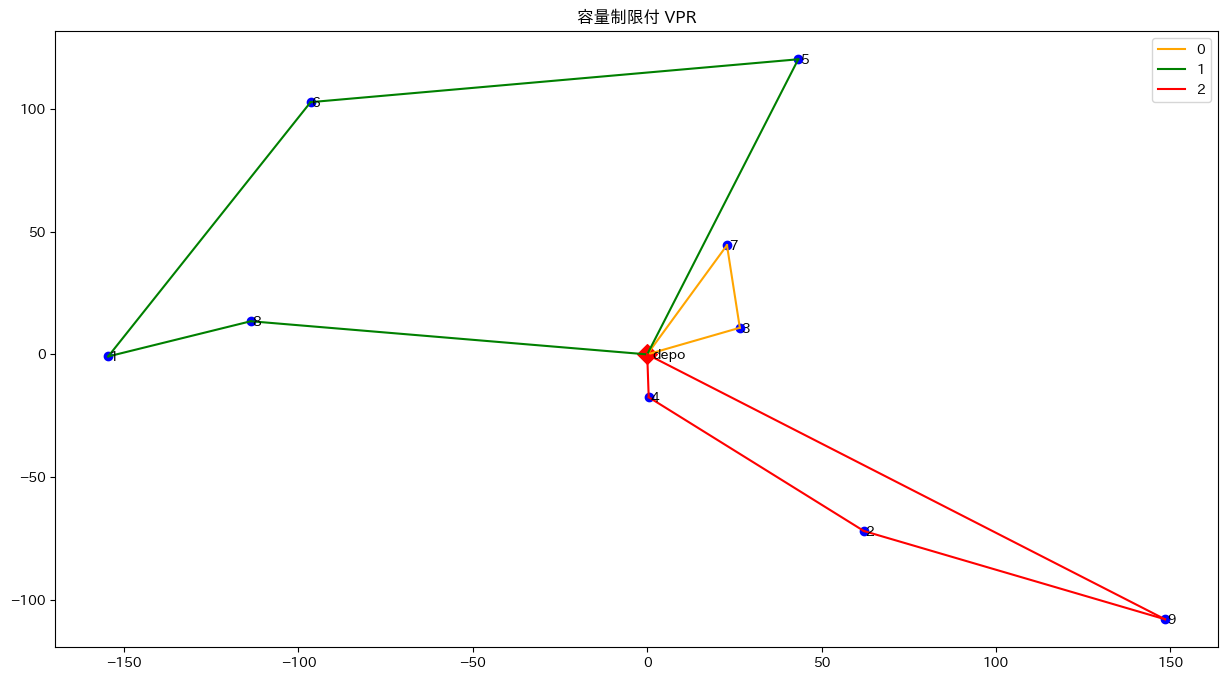

In [25]:
plt.figure(figsize=(15, 8))
plt.title("容量制限付 VPR")

plt.scatter(
    coordinate_of_places_list[0, 0],
    coordinate_of_places_list[0, 1],
    color = "red",
    marker = "D",
    s = 100
)

plt.scatter(
    coordinate_of_places_list[1:, 0],
    coordinate_of_places_list[1:, 1],
    color = "blue"
)

for i, coordinate in enumerate(coordinate_of_places_list[1:, :]):

    plt.text(
        coordinate[0] + 0.5,
        coordinate[1] - 2,
        str(i+1)
    )

plt.text(
    coordinate_of_places_list[0, 0] + 1.5,
    coordinate_of_places_list[0, 1] - 2,
    "depo"
);

vehicle_color_list = ["orange", "green", "red", "blue", "yellow", "purple"]

handles = []
labels = []

for vehicle in vehicles_list:
    for i in places_list:
        for j in places_list:
            if pulp.value(route[vehicle][i, j]) == 1:
                line, = plt.plot(
                    [coordinate_of_places_list[i, 0], coordinate_of_places_list[j, 0]],
                    [coordinate_of_places_list[i, 1], coordinate_of_places_list[j, 1]],
                    color = vehicle_color_list[vehicle]
                )
                # 凡例が重複しないための処理
                if vehicle not in labels:
                    labels.append(vehicle)
                    handles.append(line)

plt.legend(handles, labels);

In [26]:
# 最適化結果を出力
for vehicle in vehicles_list:
    for i in places_list:
        for j in places_list:
            if pulp.value(route[vehicle][i, j]) == 1:
                print(f"車両 {vehicle}: {i}->{j}")

車両 0: 0->3
車両 0: 3->7
車両 0: 7->0
車両 1: 0->5
車両 1: 1->8
車両 1: 5->6
車両 1: 6->1
車両 1: 8->0
車両 2: 0->4
車両 2: 2->9
車両 2: 4->2
車両 2: 9->0


### 時間枠制約

In [27]:
# 時間枠
from_time = {i:np.random.randint(0, 1) for i in range(num_of_places+1)} 
to_time = {i:np.random.randint(20, 24) for i in range(num_of_places+1)} 

# 移動速度(時速)
speed = 60

# 時間行列
time_matrix: List = distance.cdist(coordinate_of_places_list, coordinate_of_places_list, metric='euclidean') / speed
time_matrix = np.vstack((time_matrix, time_matrix[0]))
time_matrix = np.concatenate((time_matrix, np.array([time_matrix[:, 0]]).T), axis=1)

# 小数点以下2位を四捨五入
time_matrix = np.round(time_matrix, 1)

In [28]:
prob = pulp.LpProblem("TSPTW", pulp.LpMinimize)

# 変数1 各拠点の訪問数
visit_num = pulp.LpVariable.dicts("visit_num", places_list[1:], 0, 1, pulp.LpBinary)

# 特定ノードの訪問時間
visit_time = pulp.LpVariable.dicts("visit_time", (places_list + [num_of_places]), None, None, pulp.LpInteger)

# 変数2 拠点間の移動
route = pulp.LpVariable.dicts(
    "x",
    [(i, j) for i in (places_list) for j in (places_list[1:] + [num_of_places]) if i != j],
    0,
    1,
    pulp.LpBinary,
)

In [29]:
# 目的条件の設定 移動時間
prob += pulp.lpSum(
    time_matrix[i][j] * route[(i, j)] 
        for i in (places_list) 
        for j in (places_list[1:] + [num_of_places]) 
        if i != j
)

In [30]:
# 制約条件1 各拠点間の移動と現在地の整合性の確保
for i in places_list[1:]:
    prob += pulp.lpSum(route[(i, j)] for j in ([num_of_places] + places_list[1:]) if i != j) == visit_num[i]

for j in places_list[1:]:
    prob += pulp.lpSum(route[(i, j)] for i in (places_list) if i != j) == visit_num[j]

# 制約条件2 全部の拠点を訪問する
for i in (places_list):
    prob += pulp.lpSum(route[(i, j)] for j in places_list[1:] + [num_of_places] if i != j) == 1


# 制約条件3 移動時間の制約 1
for i in places_list:
    for j in [num_of_places] + places_list[1:]:
        if i != j:
            prob += (visit_time[i] + time_matrix[i][j] - visit_time[j]) <= (
                max(to_time[i] + time_matrix[i][j] - from_time[j], 0) * (1 - route[(i, j)])
            )
            prob += route[(i, j)] >= 0

# 制約条件4 移動時間の制約 2
for i in places_list + [num_of_places]:
    prob += visit_time[i] >= from_time[i]
    prob += visit_time[i] <= to_time[i]

In [31]:
prob.solve(pulp.PULP_CBC_CMD(threads=2, timeLimit=120))

# 最適化の実行結果
print("Status solution: ", pulp.LpStatus[prob.status])

# 時間
pulp.value(prob.objective)

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/koji/data/vrp/.venv/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/hk/4lvgvfrs6h50_v2lt9mgxgrm0000gn/T/9c6b76e43f2f4ccca43cf87d2e78b58a-pulp.mps sec 120 threads 2 timeMode elapsed branch printingOptions all solution /var/folders/hk/4lvgvfrs6h50_v2lt9mgxgrm0000gn/T/9c6b76e43f2f4ccca43cf87d2e78b58a-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 237 COLUMNS
At line 1207 RHS
At line 1440 BOUNDS
At line 1552 ENDATA
Problem MODEL has 232 rows, 111 columns and 657 elements
Coin0008I MODEL read with 0 errors
seconds was changed from 1e+100 to 120
threads was changed from 0 to 2
Option for timeMode changed from cpu to elapsed
Continuous objective value is 11.2914 - 0.00 seconds
Cgl0003I 9 fixed, 0 tightened bounds, 89 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 89 strengthened rows, 0 substitutions
Cgl0003I 0 fi

14.899999999999999

In [32]:
# ルート順の保存
edges = []

for i in places_list:
    for j in [num_of_places] + places_list[1:]:
        if i != j:
            if pulp.value(route[(i, j)]) >= 1:
                if j != num_of_places:
                    edges.append((i, j))
                else:
                    edges.append((i, 0))

# Printing path
tour = []
node = 0
for i in range(0, len(edges)):
    for j in edges:
        if node == j[0]:
            tour.append(node)
            node = j[1]
            edges.remove(j)
tour.append(0)

In [33]:
# 最適化結果の出力
for i in range(len(tour[:-1])):
    print(f"{tour[i]}->{tour[i+1]}")

0->4
4->2
2->9
9->3
3->7
7->5
5->6
6->1
1->8
8->0


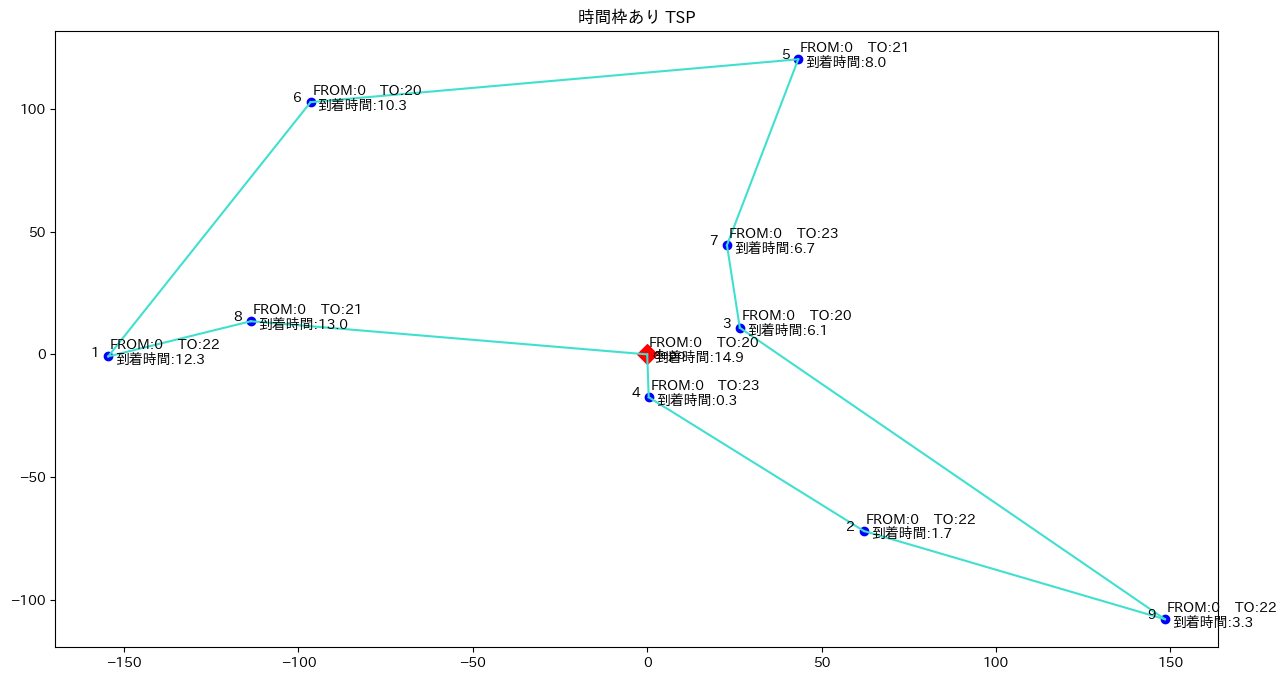

In [34]:
plt.figure(figsize=(15, 8))
plt.title("時間枠あり TSP")

# 出発点の表示
plt.scatter(
    coordinate_of_places_list[0, 0],
    coordinate_of_places_list[0, 1],
    color = "red",
    marker = "D",
    s = 100
)

# 各拠点の表示
plt.scatter(
    coordinate_of_places_list[1:, 0],
    coordinate_of_places_list[1:, 1],
    color = "blue"
)

# 場所のインデックスの表示
for i, coordinate in enumerate(coordinate_of_places_list[1:, :]):

    plt.text(
        coordinate[0] - 5,
        coordinate[1],
        str(i+1)
    )

# 時間枠の表示
for i, coordinate in enumerate(coordinate_of_places_list):

    # 時間枠 FROMの表示
    plt.text(
        coordinate[0] + 0.5,
        coordinate[1] + 3,
        f"FROM:{str(from_time[i])}"
    )

    # 時間枠TOの表示
    plt.text(
        coordinate[0] + 20,
        coordinate[1] + 3,
        f"TO:{str(to_time[i])}"
    )

# 到着時間の表示
arrival_time = 0

for i in range(len(tour[:-1])):
    arrival_time += time_matrix[tour[i]][tour[i+1]]
    plt.text(
        coordinate_of_places_list[tour[i+1], 0] + 2,
        coordinate_of_places_list[tour[i+1], 1] - 3,
        f"到着時間:{str(round(arrival_time, 1))}"
    )

# depo の文字の表示
plt.text(
    coordinate_of_places_list[0, 0] + 1.5,
    coordinate_of_places_list[0, 1] - 2,
    "depo"
);


# 巡るルートを線で表示
for i in range(len(tour[:-1])):
    plt.plot(
        [coordinate_of_places_list[tour[i], 0], coordinate_of_places_list[tour[i+1], 0]],
        [coordinate_of_places_list[tour[i], 1], coordinate_of_places_list[tour[i+1], 1]],
        color = "turquoise"
    )

## 労働時間の概念を追加 + 残業は３時間まで + 目的変数(最大)を訪問するエリアの数に変更

In [35]:
regular_hours = 8  # 8時間が定時労働
max_overtime_hours = 3  # 残業3時間まで

In [36]:
# prob = pulp.LpProblem("TSPTW", pulp.LpMinimize)

prob = pulp.LpProblem("TSPTW", pulp.LpMaximize)

# 変数1 各拠点の訪問数
visit_num = pulp.LpVariable.dicts("visit_num", places_list[1:], 0, 1, pulp.LpBinary)

# 特定ノードの訪問時間
visit_time = pulp.LpVariable.dicts("visit_time", (places_list + [num_of_places]), None, None, pulp.LpInteger)

# 変数2 拠点間の移動
route = pulp.LpVariable.dicts(
    "x",
    [(i, j) for i in (places_list) for j in (places_list[1:] + [num_of_places]) if i != j],
    0,
    1,
    pulp.LpBinary,
)

In [37]:
# 制約条件1 各拠点間の移動と現在地の整合性の確保
for i in places_list[1:]:
    prob += pulp.lpSum(route[(i, j)] for j in ([num_of_places] + places_list[1:]) if i != j) == visit_num[i]

for j in places_list[1:]:
    prob += pulp.lpSum(route[(i, j)] for i in (places_list) if i != j) == visit_num[j]

# 制約条件2 出発するのは1回のみ
prob += pulp.lpSum(route[(0, i)] for i in places_list[1:]) == 1

# 制約条件3 移動時間の制約 1
for i in places_list:
    for j in [num_of_places] + places_list[1:]:
        if i != j:
            prob += (visit_time[i] + time_matrix[i][j] - visit_time[j]) <= (
                max(to_time[i] + time_matrix[i][j] - from_time[j], 0) * (1 - route[(i, j)])
            )
            prob += route[(i, j)] >= 0

# 制約条件4 移動時間の制約 2
for i in places_list + [num_of_places]:
    prob += visit_time[i] >= from_time[i]
    prob += visit_time[i] <= to_time[i]

In [38]:
h = pulp.LpVariable(f'h', lowBound=0, cat='Continuous')

travel = pulp.lpSum([time_matrix[i][j] * route[(i, j)] for i in (places_list) for j in (places_list[1:] + [num_of_places]) if i != j]) # 移動時間
prob += (travel - regular_hours <= h)
prob += (h <= max_overtime_hours)

# 目的関数
# 回る拠点数を最大化する
prob += pulp.lpSum(route[(i, j)] for i in (places_list) for j in places_list[1:] + [num_of_places] if i != j) 

prob.solve()

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/koji/data/vrp/.venv/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/hk/4lvgvfrs6h50_v2lt9mgxgrm0000gn/T/3010545821b543bda402afbc4e462623-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/hk/4lvgvfrs6h50_v2lt9mgxgrm0000gn/T/3010545821b543bda402afbc4e462623-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 230 COLUMNS
At line 1211 RHS
At line 1437 BOUNDS
At line 1549 ENDATA
Problem MODEL has 225 rows, 112 columns and 667 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 10.9379 - 0.00 seconds
Cgl0003I 0 fixed, 0 tightened bounds, 89 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 89 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 89 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 ti

1

In [39]:
prob.solve(pulp.PULP_CBC_CMD(threads=2, timeLimit=60))

# 最適化の実行結果
print("Status solution: ", pulp.LpStatus[prob.status])

# 時間
pulp.value(prob.objective)

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/koji/data/vrp/.venv/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/hk/4lvgvfrs6h50_v2lt9mgxgrm0000gn/T/1211567f24534ab79e04c5c559648d9e-pulp.mps max sec 60 threads 2 timeMode elapsed branch printingOptions all solution /var/folders/hk/4lvgvfrs6h50_v2lt9mgxgrm0000gn/T/1211567f24534ab79e04c5c559648d9e-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 230 COLUMNS
At line 1211 RHS
At line 1437 BOUNDS
At line 1549 ENDATA
Problem MODEL has 225 rows, 112 columns and 667 elements
Coin0008I MODEL read with 0 errors
seconds was changed from 1e+100 to 60
threads was changed from 0 to 2
Option for timeMode changed from cpu to elapsed
Continuous objective value is 10.9379 - 0.00 seconds
Cgl0003I 0 fixed, 0 tightened bounds, 89 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 89 strengthened rows, 0 substitutions
Cgl0003I 0 

9.0

In [40]:
# ルート順の保存
edges = []

for i in places_list:
    for j in [num_of_places] + places_list[1:]:
        if i != j:
            if pulp.value(route[(i, j)]) >= 1:
                if j != num_of_places:
                    edges.append((i, j))
                else:
                    edges.append((i, 0))

# Printing path
tour = []
node = 0
for i in range(0, len(edges)):
    for j in edges:
        if node == j[0]:
            tour.append(node)
            node = j[1]
            edges.remove(j)
tour.append(0)

In [41]:
# 最適化結果の出力
for i in range(len(tour[:-1])):
    print(f"{tour[i]}->{tour[i+1]}")

0->0
0->1
1->8
8->6
6->5
5->3
3->7
7->4
4->0


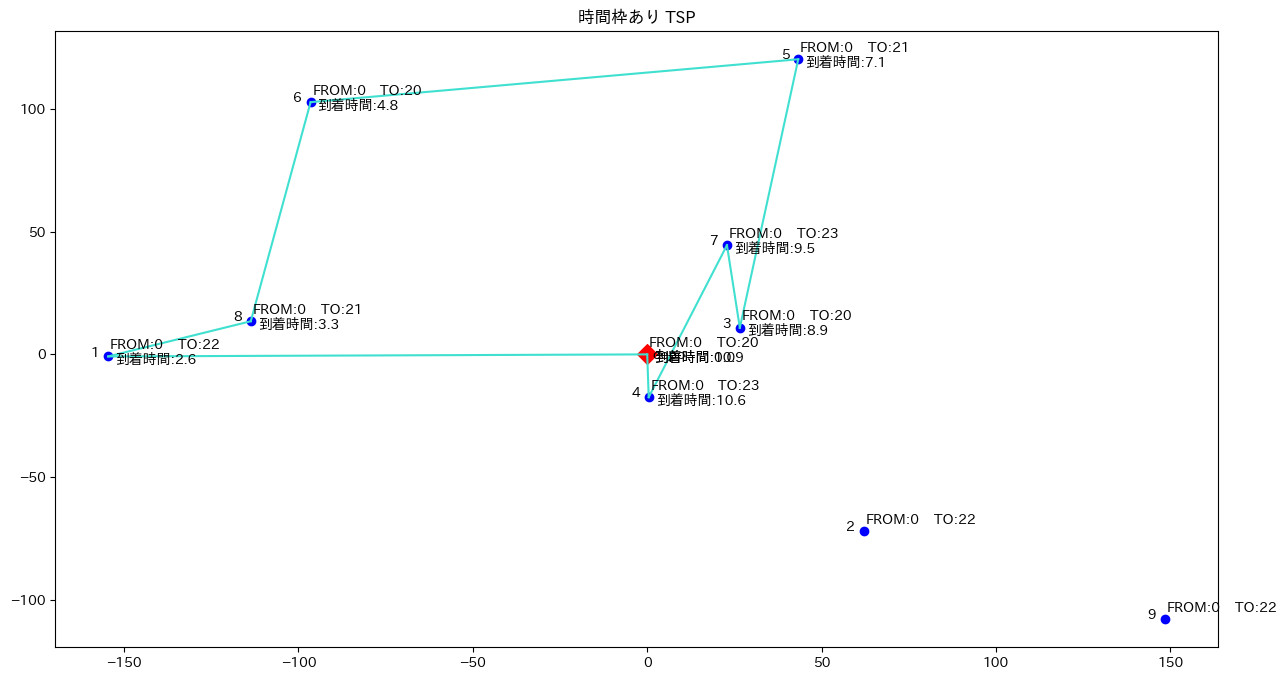

In [42]:
plt.figure(figsize=(15, 8))
plt.title("時間枠あり TSP")

# 出発点の表示
plt.scatter(
    coordinate_of_places_list[0, 0],
    coordinate_of_places_list[0, 1],
    color = "red",
    marker = "D",
    s = 100
)

# 各拠点の表示
plt.scatter(
    coordinate_of_places_list[1:, 0],
    coordinate_of_places_list[1:, 1],
    color = "blue"
)

# 場所のインデックスの表示
for i, coordinate in enumerate(coordinate_of_places_list[1:, :]):

    plt.text(
        coordinate[0] - 5,
        coordinate[1],
        str(i+1)
    )

# 時間枠の表示
for i, coordinate in enumerate(coordinate_of_places_list):

    # 時間枠 FROMの表示
    plt.text(
        coordinate[0] + 0.5,
        coordinate[1] + 3,
        f"FROM:{str(from_time[i])}"
    )

    # 時間枠TOの表示
    plt.text(
        coordinate[0] + 20,
        coordinate[1] + 3,
        f"TO:{str(to_time[i])}"
    )

# 到着時間の表示
arrival_time = 0

for i in range(len(tour[:-1])):
    arrival_time += time_matrix[tour[i]][tour[i+1]]
    plt.text(
        coordinate_of_places_list[tour[i+1], 0] + 2,
        coordinate_of_places_list[tour[i+1], 1] - 3,
        f"到着時間:{str(round(arrival_time, 1))}"
    )


# depo の文字の表示
plt.text(
    coordinate_of_places_list[0, 0] + 1.5,
    coordinate_of_places_list[0, 1] - 2,
    "depo"
);

# 巡るルートを線で表示
for i in range(len(tour[:-1])):
    plt.plot(
        [coordinate_of_places_list[tour[i], 0], coordinate_of_places_list[tour[i+1], 0]],
        [coordinate_of_places_list[tour[i], 1], coordinate_of_places_list[tour[i+1], 1]],
        color = "turquoise"
    )

In [43]:
# 2-opt
N = len(tour)

while True:
    count = 0
    for i in range(N-2):
        for j in range(i+2, N):
            l1 = distance_matrix[tour[i]][tour[i + 1]]
            l2 = distance_matrix[tour[j]][tour[(j + 1) % N]]
            l3 = distance_matrix[tour[i]][tour[j]]
            l4 = distance_matrix[tour[i + 1]][tour[(j + 1) % N]]

            if l1 + l2 > l3 + l4:

                new_tour = tour[i+1 : j+1]
                tour[i+1 : j+1] = new_tour[::-1]

                count += 1
    if count == 0:
        break

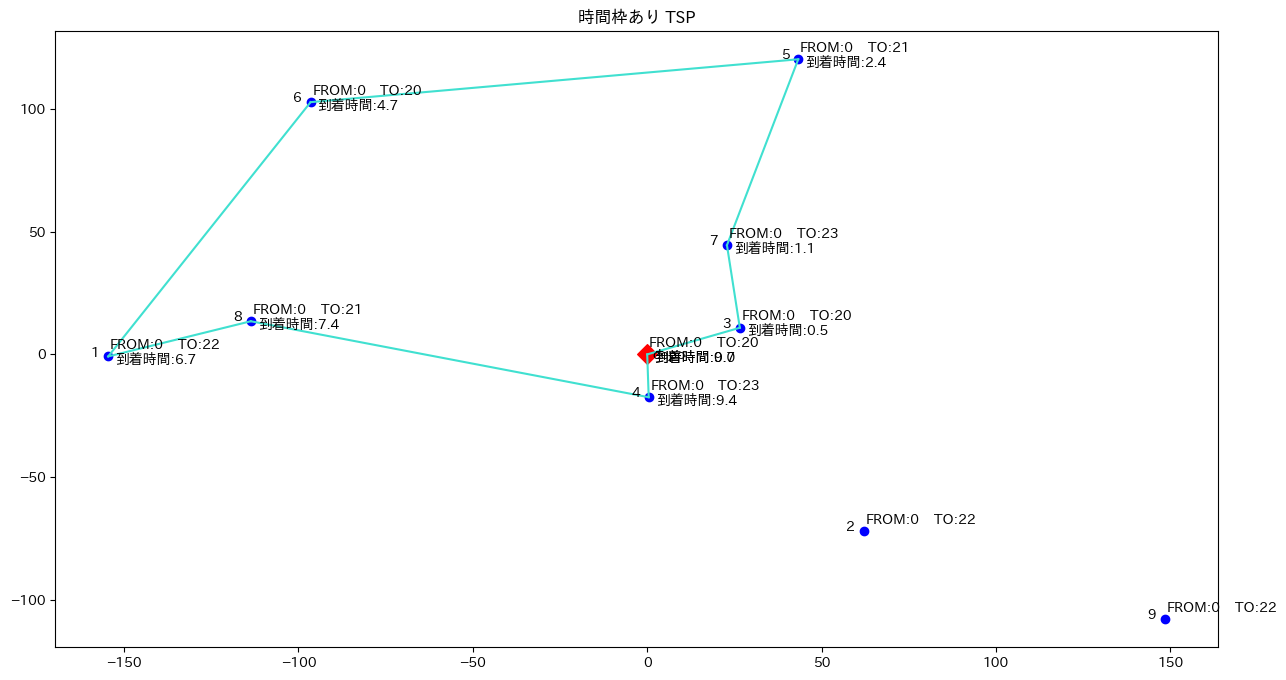

In [44]:
plt.figure(figsize=(15, 8))
plt.title("時間枠あり TSP")

# 出発点の表示
plt.scatter(
    coordinate_of_places_list[0, 0],
    coordinate_of_places_list[0, 1],
    color = "red",
    marker = "D",
    s = 100
)

# 各拠点の表示
plt.scatter(
    coordinate_of_places_list[1:, 0],
    coordinate_of_places_list[1:, 1],
    color = "blue"
)

# 場所のインデックスの表示
for i, coordinate in enumerate(coordinate_of_places_list[1:, :]):

    plt.text(
        coordinate[0] - 5,
        coordinate[1],
        str(i+1)
    )

# 時間枠の表示
for i, coordinate in enumerate(coordinate_of_places_list):

    # 時間枠 FROMの表示
    plt.text(
        coordinate[0] + 0.5,
        coordinate[1] + 3,
        f"FROM:{str(from_time[i])}"
    )

    # 時間枠TOの表示
    plt.text(
        coordinate[0] + 20,
        coordinate[1] + 3,
        f"TO:{str(to_time[i])}"
    )

# 到着時間の表示
arrival_time = 0

for i in range(len(tour[:-1])):
    arrival_time += time_matrix[tour[i]][tour[i+1]]
    plt.text(
        coordinate_of_places_list[tour[i+1], 0] + 2,
        coordinate_of_places_list[tour[i+1], 1] - 3,
        f"到着時間:{str(round(arrival_time, 1))}"
    )


# depo の文字の表示
plt.text(
    coordinate_of_places_list[0, 0] + 1.5,
    coordinate_of_places_list[0, 1] - 2,
    "depo"
);

# 巡るルートを線で表示
for i in range(len(tour[:-1])):
    plt.plot(
        [coordinate_of_places_list[tour[i], 0], coordinate_of_places_list[tour[i+1], 0]],
        [coordinate_of_places_list[tour[i], 1], coordinate_of_places_list[tour[i+1], 1]],
        color = "turquoise"
    )


## ヒューリスティック解法

## 貪欲法

In [45]:
# セールスマンが今いる場所
current_city = places_list[0]

N = len(places_list[1:])

# 未訪問の街
unvisited_cities = set(range(0, N+1))

# 巡回したツアー
tour = [current_city]

unvisited_cities.remove(current_city)

# 探索の実行
while unvisited_cities:

    # 最も近い街を次に移動する街とする
    next_city = min(unvisited_cities,
                    key=lambda city: distance_matrix[current_city][city])
    
    # 次に訪問する街を未訪問の街から除去
    unvisited_cities.remove(next_city)

    # 巡回したツアーに次に訪問する街を追加
    tour.append(next_city)

    # セールスマンが今いる場所を次に訪問する街に更新
    current_city = next_city

# 出発地点を最後の訪問地に追加
tour.append(places_list[0])

In [46]:
# 最適化結果の出力
for i, j in zip(tour[0:-1], tour[1:]):
    print(f"{i}->{j}")

0->4
4->3
3->7
7->5
5->6
6->8
8->1
1->2
2->9
9->0


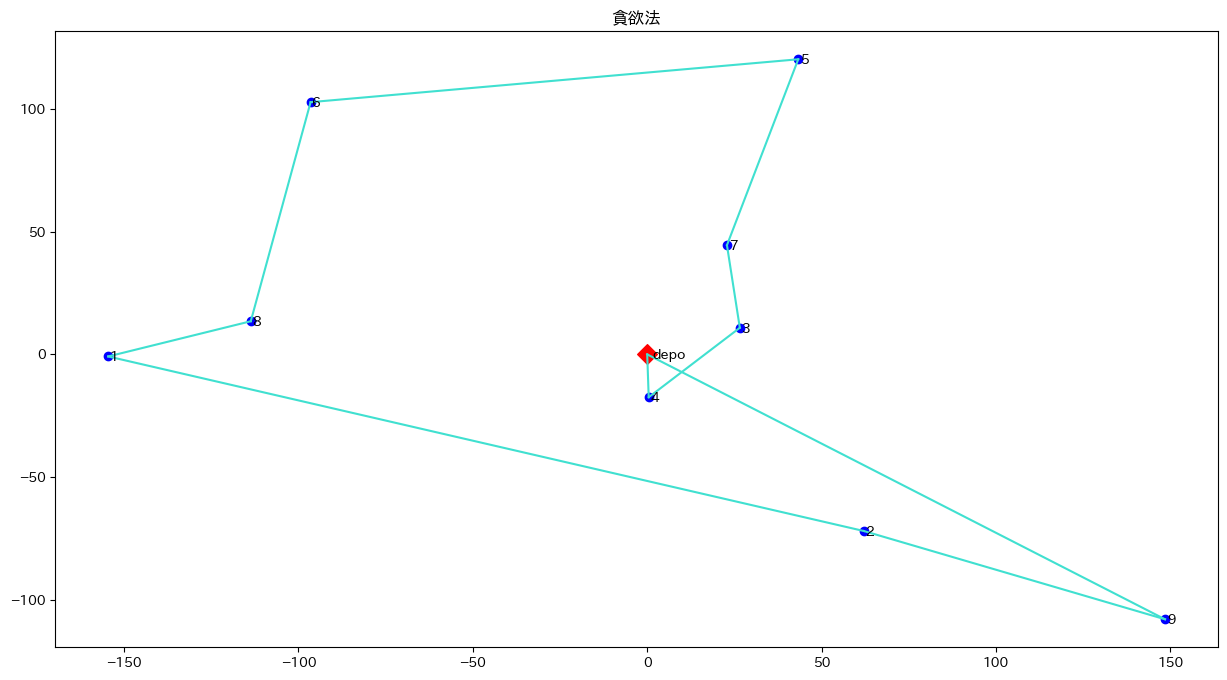

In [47]:
plt.figure(figsize=(15, 8))
plt.title("貪欲法")

plt.scatter(
    coordinate_of_places_list[0, 0],
    coordinate_of_places_list[0, 1],
    color = "red",
    marker = "D",
    s = 100
)

plt.scatter(
    coordinate_of_places_list[1:, 0],
    coordinate_of_places_list[1:, 1],
    color = "blue"
)

for i, coordinate in enumerate(coordinate_of_places_list[1:, :]):

    plt.text(
        coordinate[0] + 0.5,
        coordinate[1] - 2,
        str(i+1)
    )

plt.text(
    coordinate_of_places_list[0, 0] + 1.5,
    coordinate_of_places_list[0, 1] - 2,
    "depo"
);

for i, j in zip(tour[0:-1], tour[1:]):
    plt.plot(
        [coordinate_of_places_list[i, 0], coordinate_of_places_list[j, 0]],
        [coordinate_of_places_list[i, 1], coordinate_of_places_list[j, 1]],
        color = "turquoise"
    )

In [48]:
def plot_tour(tour, n, color):

    plt.subplot(1, 2, n)

    plt.scatter(
        coordinate_of_places_list[0, 0],
        coordinate_of_places_list[0, 1],
        color = "red",
        marker = "D",
        s = 100
    )

    plt.scatter(
        coordinate_of_places_list[1:, 0],
        coordinate_of_places_list[1:, 1],
        color = "blue"
    )

    for i, coordinate in enumerate(coordinate_of_places_list[1:, :]):

        plt.text(
            coordinate[0] + 0.5,
            coordinate[1] - 2,
            str(i+1)
        )

    plt.text(
        coordinate_of_places_list[0, 0] + 1.5,
        coordinate_of_places_list[0, 1] - 2,
        "depo"
    );

    for i, j in zip(tour[0:-1], tour[1:]):
        plt.plot(
            [coordinate_of_places_list[i, 0], coordinate_of_places_list[j, 0]],
            [coordinate_of_places_list[i, 1], coordinate_of_places_list[j, 1]],
            color = color
        )

In [49]:
def plot_2opt(i, j):

    plt.scatter(
        [coordinate_of_places_list[i, 0], coordinate_of_places_list[j, 0]], 
        [coordinate_of_places_list[i, 1], coordinate_of_places_list[j, 1]],
        color = "red"
    )
    
    plt.plot(
        [coordinate_of_places_list[i, 0], coordinate_of_places_list[j, 0]],
        [coordinate_of_places_list[i, 1], coordinate_of_places_list[j, 1]],
        color = "blue"
    )

## 2-opt

[4, 3, 7, 5, 6, 8, 1]
[1, 8, 6, 5, 7, 3, 4]



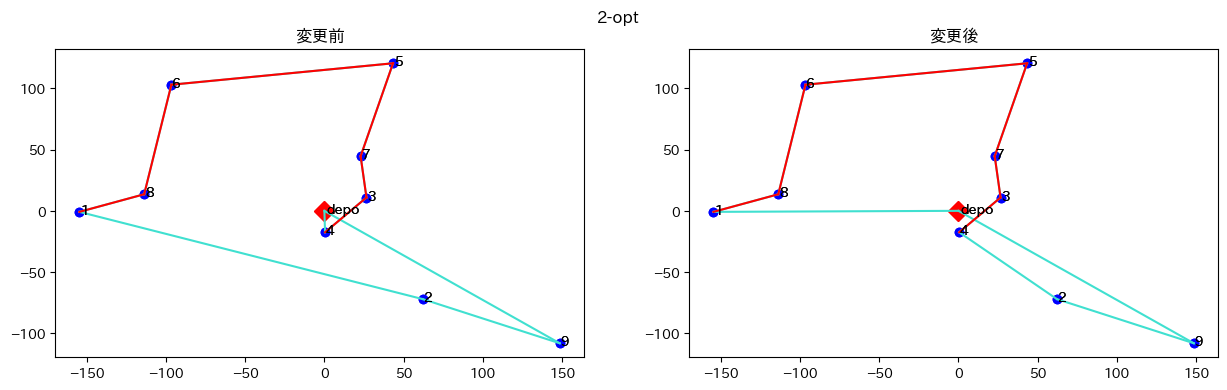

[4, 2, 9]
[9, 2, 4]



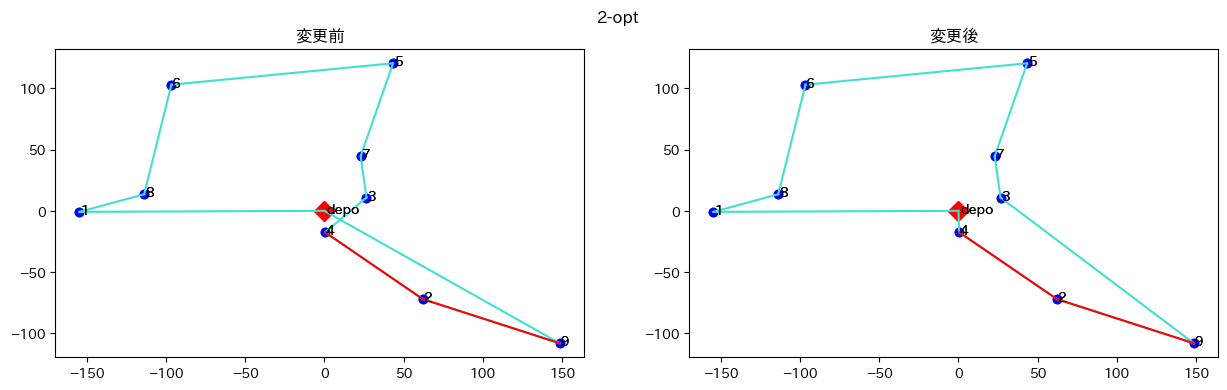

[1, 8]
[8, 1]



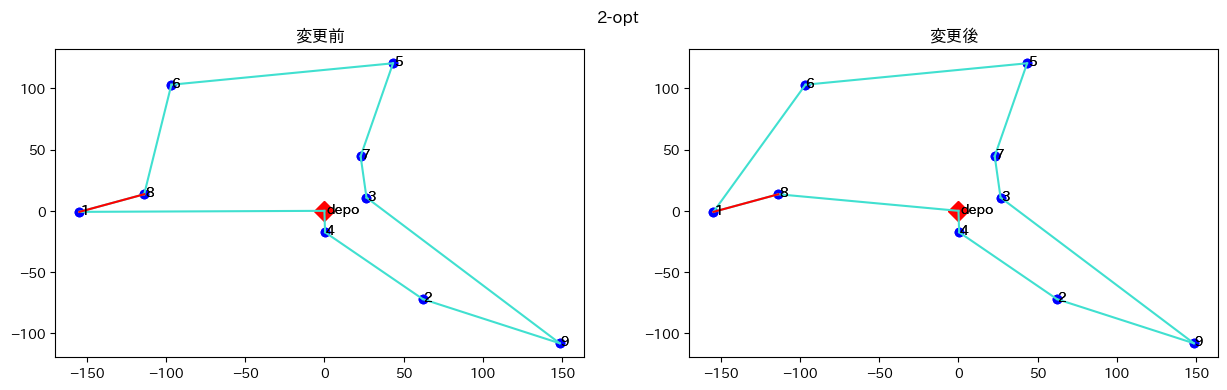

In [50]:
N = len(tour)

while True:
    count = 0
    for i in range(N-2):
        for j in range(i+2, N):
            l1 = distance_matrix[tour[i]][tour[i + 1]]
            l2 = distance_matrix[tour[j]][tour[(j + 1) % N]]
            l3 = distance_matrix[tour[i]][tour[j]]
            l4 = distance_matrix[tour[i + 1]][tour[(j + 1) % N]]

            if l1 + l2 > l3 + l4:

                plt.figure(figsize=(15, 4))
                plt.suptitle("2-opt")

                plot_tour(tour, 1, "turquoise")

                new_tour = tour[i+1 : j+1]
                tour[i+1 : j+1] = new_tour[::-1]

                print(new_tour)
                print(new_tour[::-1])
                print()

                plt.title("変更前")
                plot_tour(tour, 2, "turquoise")

                plt.title("変更後")
                plot_tour(new_tour, 1, "red")
                plot_tour(new_tour[::-1], 2, "red")

                plt.show()

                count += 1
    if count == 0:
        break

0->8
8->1
1->6
6->5
5->7
7->3
3->9
9->2
2->4
4->0


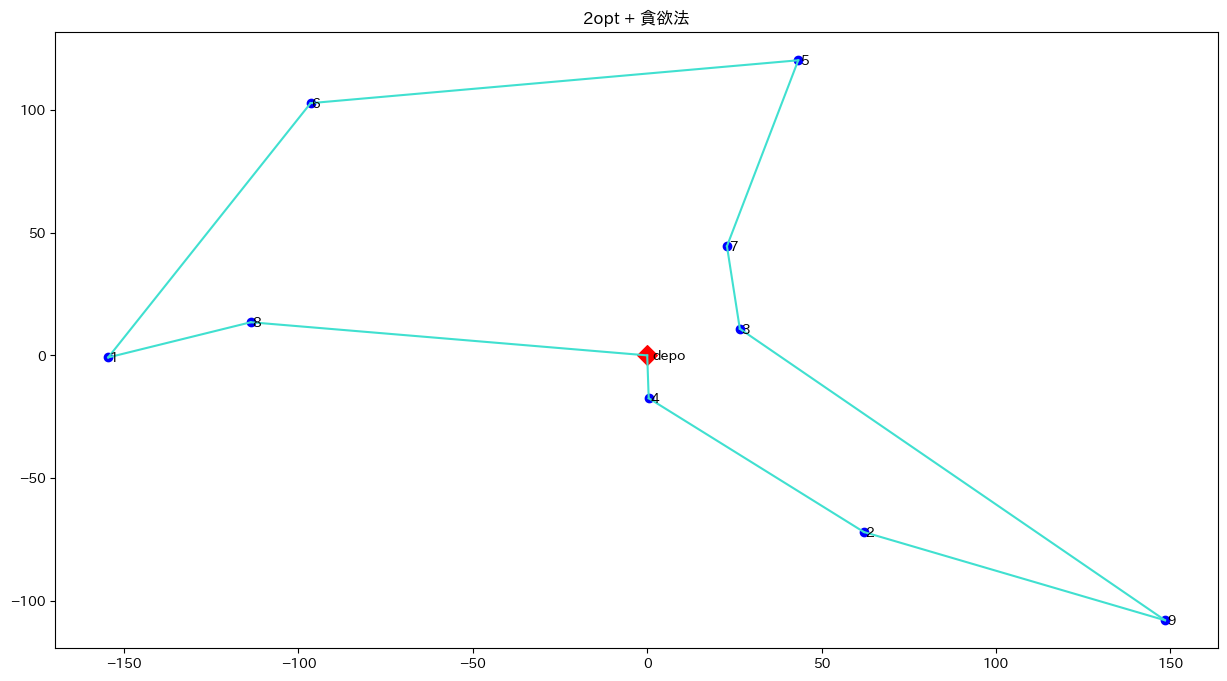

In [51]:
plt.figure(figsize=(15, 8))
plt.title("2opt + 貪欲法")

plt.scatter(
    coordinate_of_places_list[0, 0],
    coordinate_of_places_list[0, 1],
    color = "red",
    marker = "D",
    s = 100
)

plt.scatter(
    coordinate_of_places_list[1:, 0],
    coordinate_of_places_list[1:, 1],
    color = "blue"
)

for i, coordinate in enumerate(coordinate_of_places_list[1:, :]):

    plt.text(
        coordinate[0] + 0.5,
        coordinate[1] - 2,
        str(i+1)
    )

plt.text(
    coordinate_of_places_list[0, 0] + 1.5,
    coordinate_of_places_list[0, 1] - 2,
    "depo"
);

for i, j in zip(tour[0:-1], tour[1:]):
    print(f"{i}->{j}")
    plt.plot(
        [coordinate_of_places_list[i, 0], coordinate_of_places_list[j, 0]],
        [coordinate_of_places_list[i, 1], coordinate_of_places_list[j, 1]],
        color = "turquoise"
    )